In [1]:
import Pkg; Pkg.add("StatsBase")

In [175]:
n = 10
L = 8*n + 4
t = 1
Ne = Int(L / 2)

6

In [176]:
#Hamiltonian
function Hamiltonian(L,t)
    H = zeros(2*L, 2*L)
    H[1,L] = -t
    H[L,1] = -t
    H[2L,L+1] = -t
    H[L+1,2L] = -t
    for i=1:2*L
      for j=1:2*L
        if i == j + 1 || i == j - 1
          H[i,j] = -t
        end 
      end
    end
    H[L,L+1]=0
    H[L+1,L]=0
    return H
end

H = Hamiltonian(L,t);

In [177]:
#generate, convert state
using StatsBase

function Lstate(L)                                 #generate a state of length L
    Lstated, Lstateu, Lstate = zeros(L), zeros(L), zeros(L)
    randomposu = sample(collect(1:L), Int(L/4), replace=false)
    randomposd = sample(collect(1:L), Int(L/4), replace=false)
    for j in randomposu
        Lstateu[j] = 1
    end
    for j in randomposd
        Lstated[j] = -1
    end
    for i=1:L 
        if Lstated[i] == -1 && Lstateu[i] == 1
            Lstate[i] = 2
        else
            Lstate[i] = Lstated[i] + Lstateu[i]
        end
    end
    return Lstate
end

function extendedstate(Lstatevector)               #take a state of length L and make it 2*L
    L = length(Lstatevector)
    State2L = zeros(2*L)
    for j=1:L
        if Lstatevector[j] == -1
            State2L[j + L] = 1
        elseif Lstatevector[j] == 1
            State2L[j] = 1
        elseif Lstatevector[j] == 2
            State2L[j], State2L[j + L] = 1,1
        else
            State2L[j] = 0
        end
    end
    return State2L
end

function shortstate(ext_state)                    #pass trom 2*L state to L state
    L = Int(length(ext_state)/2)
    sh_state = zeros(L)
    for j=1:L
        if ext_state[j]==1
            sh_state[j]=1
        end
    end
    for j=1:L
        if ext_state[L+j]==1
            if sh_state[j]==1
                sh_state[j]=2
            else
                sh_state[j]=-1
            end
        end
    end
    return sh_state
end


shortstate (generic function with 1 method)

In [178]:
#generate a move
function Pauli(x,i,j)                 #check if state i and j are both occupied
    if x[i] == 1 && x[j] == 1
        return true
    end
    return false
end 

function occupied_states(v)         #generate a vector with positions of occupied states (from 2*L states)
    occ_states = []
    for i = 1:2*L
        if v[i] == 1
            append!(occ_states, i)
        end
    end
    return occ_states
end


function occupied_states_L(v)
    occ_states = []
    L =length(v)
    for i = 1 : L
        if abs(v[i]) == 1
            append!(occ_states, i )
            
        elseif v[i] == 2
            append!(occ_states, i )
        
        end
    end
    return occ_states
end


function move_L(w)
    
    v = copy(w)
    L = length(v)
    i = rand(occupied_states_L(v))
    j = rand(-1:2:1)

    j_pbc = mod(i+j,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

        if v[i] != v[j_pbc] && v[j_pbc]!=2

            if abs(v[i])==1
            v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2
            v[i] = 0

            elseif v[i]==2    
            spin = rand(-1:2:1)

                if v[j_pbc] != spin
                v[i] = -spin

                    if abs(v[j_pbc]) == 1 
                        v[j_pbc] = 2 
                    elseif v[j_pbc] == 0 
                        v[j_pbc] = spin 
                    end

                end    
            end
            
        end

    return v
    
end


move_L (generic function with 1 method)

In [179]:
#generate unitary matrices and the ratio of determinants
using LinearAlgebra
U = eigvecs(H)  #unitary matrix
Udag = inv(U)   #U^-1
E = eigvals(H)  #eigenvalues of H

function U1(A, Ne) #take the first Ne columns
    U_1 = A[:,1:Ne]
    return U_1
end

U_1 = U1(U,Ne)

function U_tilde(A,v)                  #takes just the rows related to occupied states, Ne*Ne matrix
    U_tild = []
    U_tild = A[occupied_states(v),:]
    return U_tild
end

function ratio_det(v, z)
    rat= det(U_tilde(U_1,z))/det(U_tilde(U_1,v))
    return rat
end  


ratio_det (generic function with 1 method)

In [180]:
#Jastrow factor
function n_i(vi)           #counts the number of els in positions vi, returning (# up , # down)
    
    n_up = 0
    n_down = 0
    
        if vi == 1
            n_up += 1
            
        elseif vi == -1
            n_down += 1
                
        elseif vi == 2
            n_down += 1
            n_up += 1
                
        end

return n_up, n_down

end

function Jastrow(state,g,v)
            
    D=length(state)       
    
    Spins=0
    Occupancies=0        
    n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : D
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n2= n_up + n_down
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg)

end

Jastrow (generic function with 1 method)

In [181]:
#This function calculates the density observable in the odd sites A
function nA(v)
    nA = 0
    for j=1:length(v)
        if j%2 != 0
            nA += sum(n_i(v[j])) 
        end
    end
    return nA*2/length(v)
end

#This function calculates the density observable in the even sites B
function nB(v)
    nB = 0
    for j=1:length(v)
        if j%2 == 0
            nB += sum(n_i(v[j])) 
        end
    end
    return nB*2/length(v)
end

nB (generic function with 1 method)

In [182]:
#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC(q0, g, v, nsteps = 1000)
    Random.seed!(1234)
    state_L = q0
    sumA=0
    sumB=0
    accepted_moves = 0
    
    Suma_A = []
    Suma_B = []
    
    for istep = 1:nsteps
        state_2L = extendedstate(state_L)
        state_new_L = move_L(state_L)
        state_new_2L = extendedstate(state_new_L)
        acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 
        
        acc = min(1,acc)
        
        if acc>rand()        #metropolis rule
            
            accepted_moves += 1
            
            n_newA= nA(state_new_L)
            sumA+=n_newA
            push!(Suma_A,n_newA)
            #push!(Suma_A,n_newA)
            
            n_newB= nB(state_new_L)
            sumB+=n_newB
            push!(Suma_B,n_newB)
            #push!(Suma_B,n_newB)
            
            state_L = copy(state_new_L)
            #compute observables
        end
    end
    return Suma_A,Suma_B, accepted_moves
end 

MC (generic function with 2 methods)

In [183]:
function average_MC(a, v) #maybe useful for question 1
    c = Int(floor(0.75*length(a)))
    b =  mean(a[c:Int(length(a))])
    return b
end

average_MC (generic function with 1 method)

In [169]:
a=Lstate(L);

0.5465195200086865
0.453480479991312

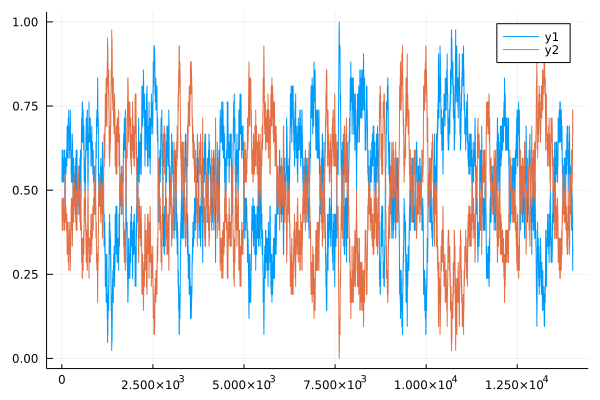

In [170]:
using Plots
v=2

MC_prova = MC(a, 10, v,100000)
print(average_MC(MC_prova[1],v),"\n")
print(average_MC(MC_prova[2],v))

x=collect(1:MC_prova[3])

p= plot(x,MC_prova[1])
plot!(x,MC_prova[2])

0.6644641463142662
0.33553585368573635

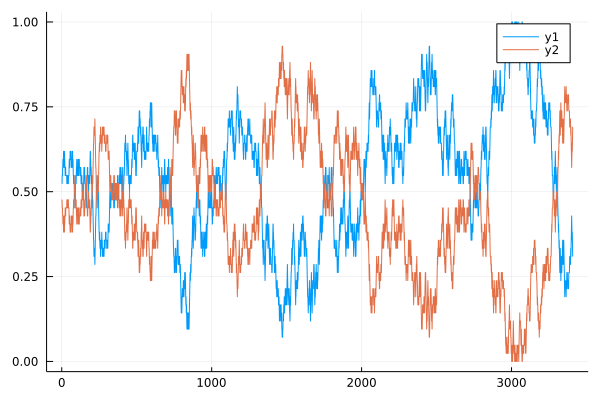

In [171]:
using Plots
v=4

MC_prova_1 = MC(a, 10, v,100000)
print(average_MC(MC_prova_1[1],v),"\n")
print(average_MC(MC_prova_1[2],v))

x=collect(1:MC_prova_1[3])

p= plot(x,MC_prova_1[1])
plot!(x,MC_prova_1[2])

0.8494113512563696
0.1505886487436305

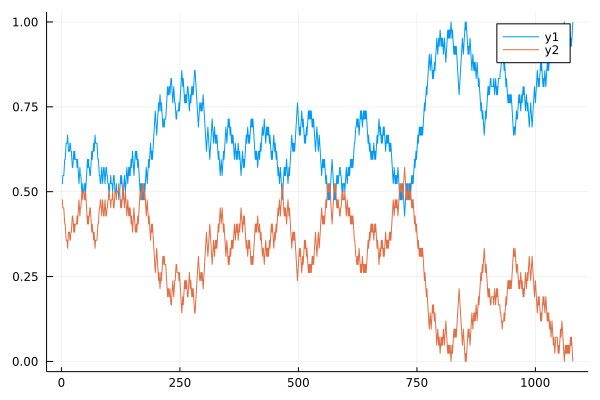

In [172]:
using Plots
v=8

MC_prova_1 = MC(a, 10, v,100000)
print(average_MC(MC_prova_1[1],v),"\n")
print(average_MC(MC_prova_1[2],v))

x=collect(1:MC_prova_1[3])

p= plot(x,MC_prova_1[1])
plot!(x,MC_prova_1[2])



In [173]:
a

84-element Vector{Float64}:
  2.0
 -1.0
  1.0
  0.0
 -1.0
  0.0
  0.0
  0.0
  0.0
 -1.0
 -1.0
  1.0
  1.0
  ⋮
  1.0
 -1.0
 -1.0
  0.0
  1.0
  1.0
  0.0
  1.0
  1.0
  1.0
  0.0
  0.0

In [174]:
sum(a)

6.0